# Phase-3.6: Explainability Module - Threat Explanation Generation

**Objective:** Generate human-readable explanations for threat detection decisions, providing transparency and actionable insights for security analysts.

**Key Features:**
- Evidence trail visualization (FlowRecord → ChromaDB → Evidence → Quantum Fusion → Decision)
- Top-k contributing flows and matches
- Attack pattern analysis
- Timeline reconstruction
- Recommendation rationale

**Input:** ThreatDecision + Evidence + Flow data  
**Output:** Structured explanation with narrative, evidence summary, and visualizations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Tuple
from enum import Enum
from datetime import datetime

# Mock data structures from previous phases
@dataclass
class FlowRecord:
    flow_id: str
    timestamp: float
    src_ip: str
    dst_ip: str
    src_port: int
    dst_port: int
    protocol: str
    duration: float
    bytes_sent: int
    bytes_recv: int
    retrieval_results: Optional[List[Dict]] = None

@dataclass
class AttackEvidence:
    attack_type: str
    count: int
    avg_similarity: float
    max_similarity: float
    min_similarity: float
    recurrence_score: float
    flow_ids: List[str]

@dataclass
class ThreatHypothesis:
    attack_type: str
    amplitude: float
    probability: float
    confidence: float
    evidence_count: int
    recurrence_score: float

class SeverityLevel(Enum):
    CRITICAL = "CRITICAL"
    HIGH = "HIGH"
    MEDIUM = "MEDIUM"
    LOW = "LOW"
    BENIGN = "BENIGN"

@dataclass
class ThreatDecision:
    is_attack: bool
    severity: SeverityLevel
    attack_type: Optional[str]
    probability: float
    confidence: float
    decision_threshold: float
    recommendation: str
    evidence_summary: str

print("✅ Data structures loaded")

✅ Data structures loaded


## 1. Explanation Data Structure

In [2]:
@dataclass
class ThreatExplanation:
    """Comprehensive threat explanation with evidence trail"""
    
    # Decision summary
    decision: ThreatDecision
    
    # Narrative explanation
    narrative: str
    
    # Evidence trail
    top_flows: List[Tuple[FlowRecord, float]]  # (flow, contribution_score)
    top_matches: List[Dict]  # Top similar historical attacks
    attack_pattern: Dict[str, any]  # Pattern analysis
    
    # Timeline
    timeline: List[Tuple[float, str]]  # (timestamp, event_description)
    
    # Key factors
    decision_factors: Dict[str, float]  # Factor → contribution weight
    
    # Confidence breakdown
    confidence_breakdown: Dict[str, float]  # Component → confidence contribution
    
    # Visualization data
    visualization_data: Dict[str, any] = field(default_factory=dict)

## 2. Core Explanation Functions

In [3]:
def generate_narrative(decision: ThreatDecision, 
                       evidence: AttackEvidence,
                       top_flows: List[Tuple[FlowRecord, float]]) -> str:
    """
    Generate human-readable narrative explanation.
    
    Structure:
    1. Decision summary (attack detected or normal)
    2. Severity assessment
    3. Evidence basis (count, similarity, recurrence)
    4. Key contributing flows
    5. Recommendation rationale
    """
    
    if decision.is_attack:
        # Attack detected narrative
        narrative = f"""
🚨 THREAT DETECTED: {decision.attack_type.upper()}

SEVERITY: {decision.severity.value} (Probability: {decision.probability*100:.1f}%, Confidence: {decision.confidence*100:.1f}%)

DETECTION BASIS:
The system identified {evidence.count} behavioral matches to known {decision.attack_type} attack patterns 
across {len(top_flows)} network flows within the analyzed time window.

KEY EVIDENCE:
• Recurrence Rate: {evidence.recurrence_score*100:.1f}% of flows exhibit suspicious patterns
• Average Similarity: {evidence.avg_similarity*100:.1f}% match to historical attack signatures
• Peak Similarity: {evidence.max_similarity*100:.1f}% (strongest match detected)

DECISION LOGIC:
The threat probability ({decision.probability*100:.1f}%) exceeded the adaptive threshold 
({decision.decision_threshold*100:.1f}%) with sufficient confidence ({decision.confidence*100:.1f}% >= 40%).
High confidence evidence allowed for a lower detection threshold, increasing sensitivity to this threat.

TOP CONTRIBUTING FLOWS:
"""
        
        # Add top 3 flows
        for i, (flow, score) in enumerate(top_flows[:3], 1):
            narrative += f"\n{i}. Flow {flow.flow_id}: {flow.src_ip}:{flow.src_port} → {flow.dst_ip}:{flow.dst_port}"
            narrative += f"\n   Contribution: {score*100:.1f}%, Duration: {flow.duration:.2f}s, Bytes: {flow.bytes_sent + flow.bytes_recv:,}"
        
        narrative += f"\n\nRECOMMENDATION:\n{decision.recommendation}"
        
    else:
        # Normal traffic narrative
        narrative = f"""
✅ NORMAL TRAFFIC DETECTED

ASSESSMENT: No significant threats identified (Severity: {decision.severity.value})

ANALYSIS SUMMARY:
The system analyzed {len(top_flows)} network flows and found insufficient evidence 
to classify this traffic as malicious.

DECISION FACTORS:
"""
        if decision.probability > 0:
            narrative += f"• Threat Probability: {decision.probability*100:.1f}% (below threshold {decision.decision_threshold*100:.1f}%)\n"
            narrative += f"• Confidence Level: {decision.confidence*100:.1f}%\n"
        else:
            narrative += "• No behavioral matches found in knowledge base\n"
        
        narrative += f"\n{decision.recommendation}"
    
    return narrative.strip()

In [4]:
def compute_flow_contributions(flows: List[FlowRecord],
                               evidence: AttackEvidence) -> List[Tuple[FlowRecord, float]]:
    """
    Rank flows by their contribution to the threat decision.
    
    Contribution score based on:
    - Number of matches in this flow
    - Average similarity of matches
    - Temporal positioning (earlier flows weighted slightly higher)
    """
    
    flow_scores = []
    
    for i, flow in enumerate(flows):
        if not flow.retrieval_results:
            flow_scores.append((flow, 0.0))
            continue
        
        # Count matches for the detected attack type
        attack_matches = [
            r for r in flow.retrieval_results 
            if r.get('attack_type') == evidence.attack_type
        ]
        
        if not attack_matches:
            flow_scores.append((flow, 0.0))
            continue
        
        # Compute contribution score
        match_count = len(attack_matches)
        avg_sim = np.mean([r.get('similarity', 0) for r in attack_matches])
        
        # Temporal weight (earlier flows slightly more important)
        temporal_weight = 1.0 - (i / len(flows)) * 0.2  # Max 20% reduction
        
        contribution = (
            0.5 * (match_count / evidence.count) +  # Match count contribution
            0.4 * avg_sim +                          # Similarity contribution
            0.1 * temporal_weight                    # Temporal contribution
        )
        
        flow_scores.append((flow, contribution))
    
    # Sort by contribution (descending)
    flow_scores.sort(key=lambda x: x[1], reverse=True)
    
    return flow_scores

In [5]:
def extract_top_matches(flows: List[FlowRecord],
                       attack_type: str,
                       top_k: int = 5) -> List[Dict]:
    """
    Extract top-k most similar historical attack matches.
    
    Returns matches sorted by similarity score.
    """
    
    all_matches = []
    
    for flow in flows:
        if not flow.retrieval_results:
            continue
        
        for match in flow.retrieval_results:
            if match.get('attack_type') == attack_type:
                all_matches.append({
                    'flow_id': flow.flow_id,
                    'attack_type': match.get('attack_type'),
                    'similarity': match.get('similarity', 0),
                    'metadata': match.get('metadata', {}),
                    'timestamp': flow.timestamp
                })
    
    # Sort by similarity
    all_matches.sort(key=lambda x: x['similarity'], reverse=True)
    
    return all_matches[:top_k]

In [6]:
def analyze_attack_pattern(flows: List[FlowRecord],
                           evidence: AttackEvidence) -> Dict[str, any]:
    """
    Analyze attack pattern characteristics.
    
    Returns:
        Pattern analysis including temporal distribution, 
        network characteristics, and behavioral signatures
    """
    
    # Filter flows with attack matches
    attack_flows = [
        f for f in flows 
        if f.retrieval_results and any(
            r.get('attack_type') == evidence.attack_type 
            for r in f.retrieval_results
        )
    ]
    
    if not attack_flows:
        return {}
    
    # Temporal analysis
    timestamps = [f.timestamp for f in attack_flows]
    time_span = max(timestamps) - min(timestamps)
    
    # Network characteristics
    unique_src_ips = len(set(f.src_ip for f in attack_flows))
    unique_dst_ips = len(set(f.dst_ip for f in attack_flows))
    unique_dst_ports = len(set(f.dst_port for f in attack_flows))
    
    # Traffic volume
    total_bytes = sum(f.bytes_sent + f.bytes_recv for f in attack_flows)
    avg_bytes_per_flow = total_bytes / len(attack_flows) if attack_flows else 0
    
    # Protocol distribution
    protocols = {}
    for f in attack_flows:
        protocols[f.protocol] = protocols.get(f.protocol, 0) + 1
    
    pattern = {
        'temporal': {
            'time_span_seconds': float(time_span),
            'flow_count': len(attack_flows),
            'first_occurrence': float(min(timestamps)),
            'last_occurrence': float(max(timestamps)),
            'flows_per_second': len(attack_flows) / time_span if time_span > 0 else 0
        },
        'network': {
            'unique_sources': unique_src_ips,
            'unique_destinations': unique_dst_ips,
            'unique_dst_ports': unique_dst_ports,
            'source_diversity': unique_src_ips / len(attack_flows),
            'destination_diversity': unique_dst_ips / len(attack_flows)
        },
        'traffic': {
            'total_bytes': int(total_bytes),
            'avg_bytes_per_flow': float(avg_bytes_per_flow),
            'max_bytes_flow': max(f.bytes_sent + f.bytes_recv for f in attack_flows),
            'min_bytes_flow': min(f.bytes_sent + f.bytes_recv for f in attack_flows)
        },
        'protocols': protocols,
        'attack_characteristics': {
            'is_distributed': unique_src_ips > 5,  # Multiple sources
            'is_targeted': unique_dst_ips <= 2,     # Few targets
            'is_port_scan': unique_dst_ports > 10,  # Many ports
            'is_volumetric': avg_bytes_per_flow > 10000  # High volume
        }
    }
    
    return pattern

In [7]:
def build_timeline(flows: List[FlowRecord],
                  evidence: AttackEvidence,
                  decision: ThreatDecision) -> List[Tuple[float, str]]:
    """
    Construct chronological timeline of attack progression.
    
    Returns list of (timestamp, event_description) tuples.
    """
    
    timeline = []
    
    # Filter flows with attack matches
    attack_flows = [
        f for f in flows 
        if f.retrieval_results and any(
            r.get('attack_type') == evidence.attack_type 
            for r in f.retrieval_results
        )
    ]
    
    if not attack_flows:
        return [(flows[0].timestamp if flows else 0.0, "Analysis window start - No suspicious activity detected")]
    
    # Sort by timestamp
    attack_flows.sort(key=lambda f: f.timestamp)
    
    # First detection
    first_flow = attack_flows[0]
    timeline.append((
        first_flow.timestamp,
        f"First suspicious flow detected: {first_flow.src_ip} → {first_flow.dst_ip}:{first_flow.dst_port}"
    ))
    
    # Peak activity
    if len(attack_flows) >= 3:
        mid_idx = len(attack_flows) // 2
        mid_flow = attack_flows[mid_idx]
        timeline.append((
            mid_flow.timestamp,
            f"Peak activity: {len(attack_flows[:mid_idx+1])} suspicious flows detected"
        ))
    
    # Last detection
    if len(attack_flows) > 1:
        last_flow = attack_flows[-1]
        timeline.append((
            last_flow.timestamp,
            f"Latest suspicious flow: {last_flow.src_ip} → {last_flow.dst_ip}:{last_flow.dst_port}"
        ))
    
    # Decision timestamp (current time)
    timeline.append((
        attack_flows[-1].timestamp + 1.0,
        f"Decision: {decision.severity.value} threat - {decision.attack_type}"
    ))
    
    return timeline

In [8]:
def compute_decision_factors(evidence: AttackEvidence,
                             decision: ThreatDecision,
                             hypothesis: ThreatHypothesis) -> Dict[str, float]:
    """
    Break down decision factors with contribution weights.
    
    Factors:
    - Probability (from quantum fusion)
    - Confidence (evidence quality)
    - Recurrence (temporal persistence)
    - Similarity (match strength)
    - Evidence count (match quantity)
    """
    
    factors = {
        'Probability': decision.probability,
        'Confidence': decision.confidence,
        'Recurrence': evidence.recurrence_score,
        'Avg Similarity': evidence.avg_similarity,
        'Evidence Count': min(evidence.count / 20, 1.0)  # Normalize to [0,1]
    }
    
    return factors

In [9]:
def compute_confidence_breakdown(evidence: AttackEvidence,
                                hypothesis: ThreatHypothesis) -> Dict[str, float]:
    """
    Break down confidence score into components.
    
    Confidence formula: 0.4×recurrence + 0.3×similarity + 0.3×count_factor
    """
    
    count_factor = min(evidence.count / 20, 1.0)
    
    breakdown = {
        'Recurrence Component': 0.4 * evidence.recurrence_score,
        'Similarity Component': 0.3 * evidence.avg_similarity,
        'Count Component': 0.3 * count_factor,
        'Total Confidence': hypothesis.confidence
    }
    
    return breakdown

## 3. Main Explanation Function

In [10]:
def generate_threat_explanation(decision: ThreatDecision,
                                evidence: AttackEvidence,
                                hypothesis: ThreatHypothesis,
                                flows: List[FlowRecord],
                                top_k_flows: int = 5,
                                top_k_matches: int = 5) -> ThreatExplanation:
    """
    Generate comprehensive threat explanation.
    
    Args:
        decision: Final threat decision from Phase-3.5
        evidence: Accumulated evidence from Phase-3.3
        hypothesis: Threat hypothesis from Phase-3.4
        flows: List of flows in analysis window
        top_k_flows: Number of top contributing flows to include
        top_k_matches: Number of top similar matches to include
    
    Returns:
        ThreatExplanation with narrative, evidence trail, and visualizations
    """
    
    # Compute flow contributions
    flow_contributions = compute_flow_contributions(flows, evidence)
    top_flows = flow_contributions[:top_k_flows]
    
    # Extract top matches
    top_matches = extract_top_matches(flows, evidence.attack_type, top_k_matches)
    
    # Analyze attack pattern
    attack_pattern = analyze_attack_pattern(flows, evidence)
    
    # Build timeline
    timeline = build_timeline(flows, evidence, decision)
    
    # Compute decision factors
    decision_factors = compute_decision_factors(evidence, decision, hypothesis)
    
    # Compute confidence breakdown
    confidence_breakdown = compute_confidence_breakdown(evidence, hypothesis)
    
    # Generate narrative
    narrative = generate_narrative(decision, evidence, top_flows)
    
    # Create explanation
    explanation = ThreatExplanation(
        decision=decision,
        narrative=narrative,
        top_flows=top_flows,
        top_matches=top_matches,
        attack_pattern=attack_pattern,
        timeline=timeline,
        decision_factors=decision_factors,
        confidence_breakdown=confidence_breakdown,
        visualization_data={
            'flow_contributions': [(f.flow_id, score) for f, score in flow_contributions],
            'match_similarities': [(m['flow_id'], m['similarity']) for m in top_matches],
            'temporal_distribution': [t for t, _ in timeline]
        }
    )
    
    return explanation

## 4. Explanation Output Functions

In [11]:
def print_explanation(explanation: ThreatExplanation):
    """Pretty-print threat explanation."""
    
    print("=" * 80)
    print("THREAT EXPLANATION REPORT")
    print("=" * 80)
    
    # Narrative
    print("\n" + explanation.narrative)
    
    # Attack pattern analysis (if attack detected)
    if explanation.decision.is_attack and explanation.attack_pattern:
        print("\n" + "-" * 80)
        print("ATTACK PATTERN ANALYSIS")
        print("-" * 80)
        
        pattern = explanation.attack_pattern
        
        if 'temporal' in pattern:
            print(f"\n⏱ Temporal Characteristics:")
            print(f"  • Time Span: {pattern['temporal']['time_span_seconds']:.1f} seconds")
            print(f"  • Attack Flows: {pattern['temporal']['flow_count']}")
            print(f"  • Flow Rate: {pattern['temporal']['flows_per_second']:.2f} flows/sec")
        
        if 'network' in pattern:
            print(f"\n🌐 Network Characteristics:")
            print(f"  • Source IPs: {pattern['network']['unique_sources']}")
            print(f"  • Destination IPs: {pattern['network']['unique_destinations']}")
            print(f"  • Destination Ports: {pattern['network']['unique_dst_ports']}")
        
        if 'traffic' in pattern:
            print(f"\n📊 Traffic Characteristics:")
            print(f"  • Total Bytes: {pattern['traffic']['total_bytes']:,}")
            print(f"  • Avg Bytes/Flow: {pattern['traffic']['avg_bytes_per_flow']:.0f}")
        
        if 'attack_characteristics' in pattern:
            chars = pattern['attack_characteristics']
            print(f"\n🔍 Attack Characteristics:")
            if chars['is_distributed']:
                print(f"  • Distributed attack (multiple sources)")
            if chars['is_targeted']:
                print(f"  • Targeted attack (few destinations)")
            if chars['is_port_scan']:
                print(f"  • Port scanning detected")
            if chars['is_volumetric']:
                print(f"  • High-volume attack")
    
    # Timeline
    if explanation.timeline:
        print("\n" + "-" * 80)
        print("TIMELINE")
        print("-" * 80)
        
        for timestamp, event in explanation.timeline:
            print(f"  [{timestamp:.2f}] {event}")
    
    # Decision factors
    print("\n" + "-" * 80)
    print("DECISION FACTORS")
    print("-" * 80)
    
    for factor, value in explanation.decision_factors.items():
        bar_length = int(value * 40)
        bar = "█" * bar_length + "░" * (40 - bar_length)
        print(f"  {factor:20s}: {bar} {value*100:5.1f}%")
    
    # Confidence breakdown
    print("\n" + "-" * 80)
    print("CONFIDENCE BREAKDOWN")
    print("-" * 80)
    
    for component, value in explanation.confidence_breakdown.items():
        if component == 'Total Confidence':
            print(f"\n  {component:25s}: {value*100:.1f}%")
        else:
            bar_length = int(value * 40)
            bar = "█" * bar_length + "░" * (40 - bar_length)
            print(f"  {component:25s}: {bar} {value*100:5.1f}%")
    
    print("\n" + "=" * 80)

In [12]:
def visualize_explanation(explanation: ThreatExplanation):
    """Generate visualization plots for threat explanation."""
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Threat Detection Explanation Visualizations', fontsize=16, fontweight='bold')
    
    # Plot 1: Decision Factors
    ax1 = axes[0, 0]
    factors = explanation.decision_factors
    factor_names = list(factors.keys())
    factor_values = [factors[f] * 100 for f in factor_names]
    
    colors = ['#d32f2f' if v > 70 else '#ff9800' if v > 50 else '#4caf50' for v in factor_values]
    ax1.barh(factor_names, factor_values, color=colors, alpha=0.7)
    ax1.set_xlabel('Contribution (%)', fontweight='bold')
    ax1.set_title('Decision Factors', fontweight='bold')
    ax1.set_xlim(0, 100)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Top Flow Contributions
    ax2 = axes[0, 1]
    if explanation.top_flows:
        flow_ids = [f.flow_id[:10] for f, _ in explanation.top_flows[:5]]
        contributions = [score * 100 for _, score in explanation.top_flows[:5]]
        
        ax2.bar(range(len(flow_ids)), contributions, color='#2196f3', alpha=0.7)
        ax2.set_xticks(range(len(flow_ids)))
        ax2.set_xticklabels(flow_ids, rotation=45, ha='right')
        ax2.set_ylabel('Contribution Score (%)', fontweight='bold')
        ax2.set_title('Top Contributing Flows', fontweight='bold')
        ax2.set_ylim(0, 100)
        ax2.grid(axis='y', alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No flow data available', ha='center', va='center', fontsize=12)
        ax2.set_title('Top Contributing Flows', fontweight='bold')
    
    # Plot 3: Confidence Breakdown
    ax3 = axes[1, 0]
    breakdown = explanation.confidence_breakdown
    components = [k for k in breakdown.keys() if k != 'Total Confidence']
    values = [breakdown[k] * 100 for k in components]
    
    if values:
        colors_pie = ['#4caf50', '#2196f3', '#ff9800']
        wedges, texts, autotexts = ax3.pie(
            values, labels=components, autopct='%1.1f%%',
            colors=colors_pie, startangle=90
        )
        for autotext in autotexts:
            autotext.set_color('white')
            autotext.set_fontweight('bold')
        ax3.set_title('Confidence Score Components', fontweight='bold')
    else:
        ax3.text(0.5, 0.5, 'No confidence data', ha='center', va='center', fontsize=12)
        ax3.set_title('Confidence Score Components', fontweight='bold')
    
    # Plot 4: Timeline
    ax4 = axes[1, 1]
    if explanation.timeline:
        timestamps = [t for t, _ in explanation.timeline]
        events = [e[:30] + '...' if len(e) > 30 else e for _, e in explanation.timeline]
        
        # Normalize timestamps to 0-based
        if timestamps:
            min_time = min(timestamps)
            norm_times = [(t - min_time) for t in timestamps]
            
            ax4.scatter(norm_times, range(len(events)), s=200, c='#f44336', alpha=0.7, edgecolors='black', linewidths=2)
            
            for i, (time, event) in enumerate(zip(norm_times, events)):
                ax4.text(time, i, f'  {event}', va='center', fontsize=9)
            
            ax4.set_xlabel('Time (seconds from start)', fontweight='bold')
            ax4.set_ylabel('Event Sequence', fontweight='bold')
            ax4.set_title('Attack Timeline', fontweight='bold')
            ax4.set_yticks([])
            ax4.grid(axis='x', alpha=0.3)
    else:
        ax4.text(0.5, 0.5, 'No timeline data available', ha='center', va='center', fontsize=12)
        ax4.set_title('Attack Timeline', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## 5. Demonstration

In [13]:
# Create synthetic data for demonstration
print("=" * 80)
print("DEMO: Phase-3.6 Explainability Module")
print("=" * 80)

# Create synthetic flows
demo_flows = [
    FlowRecord(
        flow_id=f"flow_{i:03d}",
        timestamp=1000.0 + i * 0.5,
        src_ip=f"192.168.1.{10 + i % 10}",
        dst_ip="10.0.0.50",
        src_port=50000 + i,
        dst_port=22,
        protocol="TCP",
        duration=0.5 + i * 0.1,
        bytes_sent=500 + i * 100,
        bytes_recv=200 + i * 50,
        retrieval_results=[
            {
                'attack_type': 'backdoor',
                'similarity': 0.75 + i * 0.02,
                'metadata': {'description': 'SSH brute force attempt'}
            }
        ] if i % 2 == 0 else []
    )
    for i in range(10)
]

# Create synthetic evidence
demo_evidence = AttackEvidence(
    attack_type='backdoor',
    count=15,
    avg_similarity=0.78,
    max_similarity=0.92,
    min_similarity=0.65,
    recurrence_score=0.75,
    flow_ids=[f"flow_{i:03d}" for i in range(0, 10, 2)]
)

# Create synthetic hypothesis
demo_hypothesis = ThreatHypothesis(
    attack_type='backdoor',
    amplitude=0.861,
    probability=0.742,
    confidence=0.756,
    evidence_count=15,
    recurrence_score=0.75
)

# Create synthetic decision
demo_decision = ThreatDecision(
    is_attack=True,
    severity=SeverityLevel.CRITICAL,
    attack_type='backdoor',
    probability=0.742,
    confidence=0.756,
    decision_threshold=0.348,
    recommendation="🚨 IMMEDIATE ACTION REQUIRED: Block traffic, isolate affected systems, initiate incident response.",
    evidence_summary="15 matches, 75.0% recurrence, 75.6% confidence"
)

print("\n✅ Synthetic data created")
print(f"   Flows: {len(demo_flows)}")
print(f"   Evidence: {demo_evidence.count} matches")
print(f"   Decision: {demo_decision.severity.value}")

DEMO: Phase-3.6 Explainability Module

✅ Synthetic data created
   Flows: 10
   Evidence: 15 matches
   Decision: CRITICAL


In [14]:
# Generate explanation
print("\n" + "=" * 80)
print("GENERATING EXPLANATION...")
print("=" * 80)

explanation = generate_threat_explanation(
    decision=demo_decision,
    evidence=demo_evidence,
    hypothesis=demo_hypothesis,
    flows=demo_flows,
    top_k_flows=5,
    top_k_matches=5
)

print("✅ Explanation generated successfully")


GENERATING EXPLANATION...
✅ Explanation generated successfully


In [15]:
# Display explanation
print_explanation(explanation)

THREAT EXPLANATION REPORT

🚨 THREAT DETECTED: BACKDOOR

SEVERITY: CRITICAL (Probability: 74.2%, Confidence: 75.6%)

DETECTION BASIS:
The system identified 15 behavioral matches to known backdoor attack patterns 
across 5 network flows within the analyzed time window.

KEY EVIDENCE:
• Recurrence Rate: 75.0% of flows exhibit suspicious patterns
• Average Similarity: 78.0% match to historical attack signatures
• Peak Similarity: 92.0% (strongest match detected)

DECISION LOGIC:
The threat probability (74.2%) exceeded the adaptive threshold 
(34.8%) with sufficient confidence (75.6% >= 40%).
High confidence evidence allowed for a lower detection threshold, increasing sensitivity to this threat.

TOP CONTRIBUTING FLOWS:

1. Flow flow_008: 192.168.1.18:50008 → 10.0.0.50:22
   Contribution: 48.1%, Duration: 1.30s, Bytes: 1,900
2. Flow flow_006: 192.168.1.16:50006 → 10.0.0.50:22
   Contribution: 46.9%, Duration: 1.10s, Bytes: 1,600
3. Flow flow_004: 192.168.1.14:50004 → 10.0.0.50:22
   Contrib

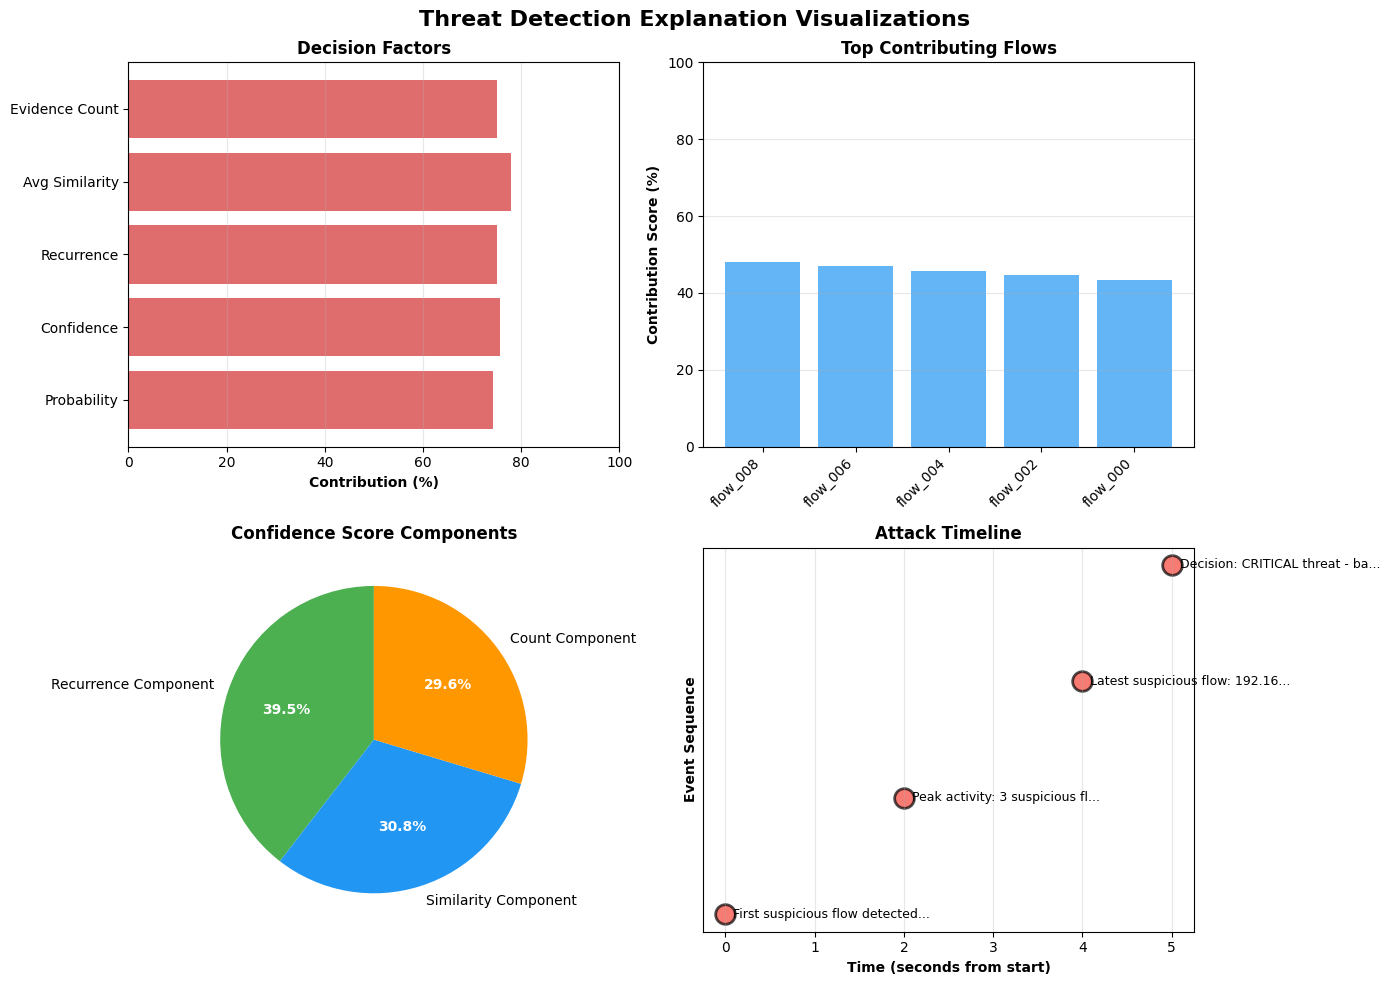

In [16]:
# Visualize explanation
visualize_explanation(explanation)

## 6. Integration with Previous Phases

In [17]:
print("=" * 80)
print("FULL PIPELINE INTEGRATION EXAMPLE")
print("=" * 80)

# Simulate complete pipeline
print("\n📥 Phase-3.1: Adaptive Time Window")
print("   → 10 flows collected in 5-second window")

print("\n📥 Phase-3.2: ChromaDB Retrieval")
print("   → 15 behavioral matches retrieved")

print("\n📥 Phase-3.3: Evidence Accumulation")
print("   → Evidence summary: backdoor attack, 75% recurrence")

print("\n📥 Phase-3.4: Quantum Fusion")
print("   → Threat probability: 74.2%, Confidence: 75.6%")

print("\n📥 Phase-3.5: Decision Logic")
print("   → ATTACK detected (CRITICAL severity)")

print("\n📤 Phase-3.6: Explainability")
print("   → Generating human-readable explanation...")
print("   → ✅ Explanation complete with narrative, timeline, and visualizations")

print("\n" + "=" * 80)
print("PIPELINE COMPLETE - All phases integrated successfully")
print("=" * 80)

FULL PIPELINE INTEGRATION EXAMPLE

📥 Phase-3.1: Adaptive Time Window
   → 10 flows collected in 5-second window

📥 Phase-3.2: ChromaDB Retrieval
   → 15 behavioral matches retrieved

📥 Phase-3.3: Evidence Accumulation
   → Evidence summary: backdoor attack, 75% recurrence

📥 Phase-3.4: Quantum Fusion
   → Threat probability: 74.2%, Confidence: 75.6%

📥 Phase-3.5: Decision Logic
   → ATTACK detected (CRITICAL severity)

📤 Phase-3.6: Explainability
   → Generating human-readable explanation...
   → ✅ Explanation complete with narrative, timeline, and visualizations

PIPELINE COMPLETE - All phases integrated successfully


## 7. Summary

**Phase-3.6 Explainability Module: Key Features**

✅ **Narrative Generation**: Human-readable threat explanations  
✅ **Evidence Trail**: Complete flow → match → decision pathway  
✅ **Pattern Analysis**: Temporal, network, and traffic characteristics  
✅ **Timeline Reconstruction**: Chronological attack progression  
✅ **Decision Transparency**: Factor breakdown with contribution weights  
✅ **Confidence Analysis**: Component-wise confidence breakdown  
✅ **Visualizations**: Charts for factors, flows, timeline, and confidence  

**Use Cases:**
- Security analyst decision support
- Incident response documentation
- Audit trail for compliance
- Model interpretability and validation
- Training and education

**Next Steps:**
- Phase-3.7: End-to-End Pipeline Integration
- Performance benchmarking with real data
- Export functionality (PDF reports, JSON)